In [1]:
import torch
from torch import nn
from d2l import torch as d2l
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import SGD
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
data = np.genfromtxt('try.csv', delimiter=',')

In [3]:
data.shape

(502614,)

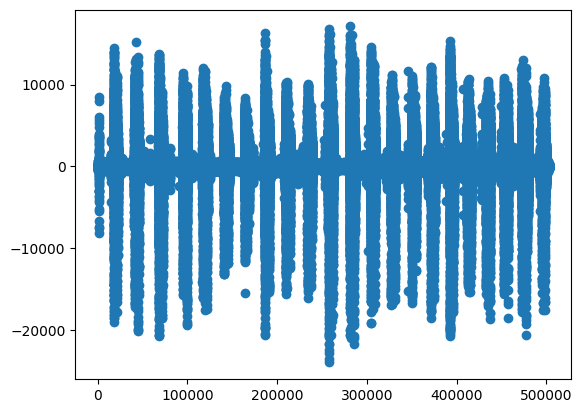

In [4]:
# 创建画布
plt.figure()
# 创建参数，将数据描起来
plt.scatter(range(len(data)),data)
# 展示
plt.show()

In [5]:
class Net(torch.nn.Module):
    # 初始化函数，接受自定义输入特征维数，隐藏层特征维数，输出层特征维数
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden, dtype=torch.float64)
        self.predict = torch.nn.Linear(n_hidden, n_output, dtype=torch.float64)
        
    # 前向传播过程
    def forward(self, x):
        x = F.relu(self.hidden(x))
        x = self.predict(x)
        out = F.log_softmax(x, dim=1)
        return out

In [6]:
class ExponentialMovingAverage:
    def __init__(self, alpha):
        self.alpha = alpha
        self.shadow_variable = None

    def update(self, var):
        if self.shadow_variable is None:
            self.shadow_variable = var.clone()
        else:
            self.shadow_variable = self.alpha * self.shadow_variable + (1 - self.alpha) * var
        return self.shadow_variable
    
    def values(self, data):
        values_get=[]
        for value in torch.tensor(data):
            avg = self.update(value)
            values_get.append(avg)
        return torch.tensor(values_get)
        


alpha = 0.9
ema = ExponentialMovingAverage(alpha)    
values = ema.values(data)

In [7]:
print(values.shape)

torch.Size([502614])


In [8]:
class Get_k:
    def __init__(self, data, left_avg=0, right_avg=0, length=2):
        self.data = list(data)
        self.left_avg = left_avg
        self.right_avg = right_avg
        self.length = length
        
    def add_to_data(self):
        left_list = []
        for i in range(self.length):
            left_list.append(self.left_avg)
        right_list = []
        for i in range(self.length):
            right_list.append(self.right_avg)
        data = left_list
        data.extend(self.data)
        data.extend(right_list)
        return data
    
    def get_k(self):
        list_k = []
        data = self.add_to_data()
        for i in range(self.length,len(data)-self.length):
            k_1 = (data[i+self.length]-data[i])/self.length
            k_2 = (-data[i-self.length]+data[i])/self.length
            k_3 = (data[i+self.length]-data[i-self.length])/(self.length*2)
            k = (k_1 + k_2 + k_3)/3
            list_k.append(k)
        return list_k    

In [9]:
the_k_data = Get_k(data)
k = the_k_data.get_k()
k_data = torch.tensor(k)
k_data.shape

torch.Size([502614])

In [10]:
def get_output(path, delimiter=','):
    output = np.genfromtxt(path ,delimiter=delimiter)
    # 获取结果 y
    col_1 = torch.zeros([1,502614])
    col_2 = torch.zeros([1,502614])
    col_3 = torch.zeros([1,502614])
    num_right = 1
    k = 0
    for data_ in output:
        num_left = int(data_[0])
        col_3[0][num_left-2:num_left+2]=1
        if k==1:
            col_1[0][num_right:num_left]=1
        
        num_right = int(data_[1])
        k = 1
        col_3[0][num_right-2:num_right+2]=1
        col_2[0][num_left:num_right]=1
    
    y = torch.cat((col_1,col_2,col_3),dim=0)
    return y.reshape(3,-1).T

In [11]:
x = torch.cat((torch.tensor(data).reshape(1,-1),values.reshape(1,-1),k_data.reshape(1,-1)),dim=0).to(torch.float64)
x = x.T
print(x.shape)
y = get_output('output.csv', delimiter=',')
print(y.shape)

torch.Size([502614, 3])
torch.Size([502614, 3])


In [12]:
net = Net(n_feature=3, n_hidden=4, n_output=3)

In [13]:
batch_size, lr, num_epochs = 10000, 0.01, 100

criterion = nn.CrossEntropyLoss()  
optimizer = SGD(net.parameters(), lr=lr)

losses = []

for epoch in range(num_epochs):  # 使用epoch作为迭代变量  
    # 数据集传入网络前向计算  
    prediction = net(x)  
    # 计算loss  
    loss = criterion(prediction, y)
    # 清除网络状态  
    optimizer.zero_grad()  
    # loss反向传播  
    loss.backward()
    # 更新参数  
    optimizer.step()
    # 输出loss大小
    losses.append(loss.item())

hidden.weight tensor([[-0.0402,  0.0503,  0.1393],
        [-0.0056, -0.1015, -0.1085],
        [ 0.0079, -0.0206, -0.0034],
        [ 0.0351,  0.0613, -0.0065]], dtype=torch.float64)
hidden.bias tensor([-0.2788, -0.3467,  0.3579, -0.2771], dtype=torch.float64)
predict.weight tensor([[ 0.1148, -0.0834, -0.1056,  0.1147],
        [ 0.1182, -0.0764, -0.1023,  0.1186],
        [-0.1159, -0.4264, -0.1242, -0.3015]], dtype=torch.float64)
predict.bias tensor([ 0.1705,  0.0666, -0.1725], dtype=torch.float64)


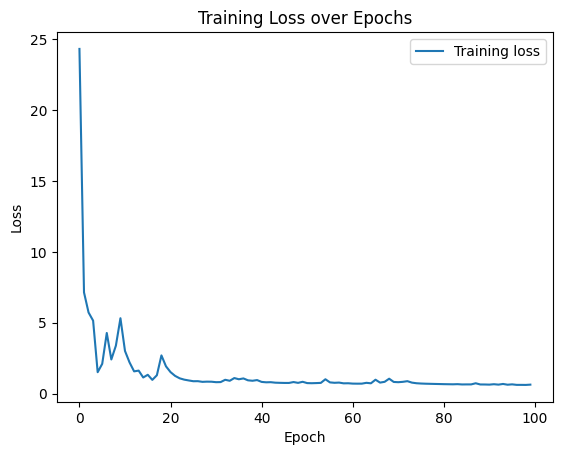

24.33063306153757
7.143831447968603
5.7240222435967185
5.150886850288557
1.5102646489510652
2.1021402370258206
4.278785888570144
2.409107930389902
3.3837314396729714
5.320393141292877
3.0087708022741215
2.199732337021581
1.5695775399289071
1.621538345155821
1.1372546504221321
1.3277305018694667
0.9678264893219376
1.2953760579718698
2.6958905252979126
1.9240075527311935
1.5160643099350741
1.2499011527304675
1.0789874329805047
0.9854774091038475
0.9270451951433106
0.8732723094390894
0.8765488680907628
0.8292096150946242
0.8429832329946149
0.8385055514385547
0.8055952935696904
0.8126083925185514
0.9745828412638542
0.9043683161200928
1.0967484852253917
1.0120255191865069
1.070180930662189
0.936690117043155
0.9057257356149032
0.9539905785395871
0.8247656939496993
0.7965211610048742
0.8052417444254676
0.770346616717096
0.7597005737885463
0.7520260890568732
0.7514833046793274
0.8146334337287535
0.7571078899634308
0.8329725458807126
0.7406996713867676
0.7325011189150178
0.7424795049521523
0.75

In [14]:
for name, param in net.named_parameters():  
    print(name, param.data)
# 绘制损失随epoch的变化  
plt.figure()  
plt.plot(losses, label='Training loss')  
plt.xlabel('Epoch')  
plt.ylabel('Loss')  
plt.title('Training Loss over Epochs')  
plt.legend()  
plt.show()

for loss_ in losses:
    print(loss_)